In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, clear_output
from time import sleep
from livelossplot import PlotLosses
import tensorflow as tf
import numpy as np
import seaborn as sns; 
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from scipy.stats import norm, uniform
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
slim = tf.contrib.slim
from tqdm.notebook import tqdm
import sys
sys.path.append('../models/')
sys.path.append('../')
from kl_utils import *

print(tf.__version__)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

1.15.0


In [2]:
num_samples = 100000
N=500
bs=500
deep=False
reset(4)

def get_data(mu_1=0.,mu_2=2.,mu_3=0.,scale_p=0.1,scale_q=0.1,scale_m=1.,mtype="mix"):
    
    p = tfd.Normal(loc=mu_1, scale=scale_p)
    q = tfd.Normal(loc=mu_2, scale=scale_q) 
   
    m = tfp.distributions.Cauchy(loc=mu_3, scale=scale_m)
    
        
    p_samples_ = p.sample([num_samples]) 
    q_samples_ = q.sample([num_samples])
    m_samples_ = m.sample([num_samples])
    
    with tf.Session() as sess:
        p_,q_,m_ = sess.run([p_samples_, q_samples_, m_samples_],feed_dict={})
        sess.close() 
    
    return p, q, m, p_,q_,m_

mu_1=2.
mu_2=-2.
mu_3=0.

scale_p=0.1
scale_q=0.2
scale_m=2.

# Generate dataset
p, q, m, p_list, q_list, m_list = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)
_, _, _, p_list_test, _, m_list_test = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)

print(p_list.shape)



(100000,)


In [3]:
p_samples = tf.placeholder(tf.float32, shape=[None])
q_samples = tf.placeholder(tf.float32, shape=[None])
m_samples = tf.placeholder(tf.float32, shape=[None])

dloss = get_loss(p_samples, q_samples, m_samples)
optim = get_optim(dloss, lr=0.001)

log_ratio_p_q, _, kld = get_gt_ratio_kl(p,q,m_samples)
_, kl_from_pq, _ = get_gt_ratio_kl(p,q,p_samples)
kl_from_cob = get_kl_from_cob(p_samples)

log_ratio_p_m = get_logits(m_samples)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# %matplotlib inline
# sample_and_plot(sess, kl_from_pq, kl_from_cob, kld, p_samples, q_samples, m_samples, log_ratio_p_q, log_ratio_p_m, mu_1, mu_2, scale_p, scale_q, mu_3, scale_m, training=False)




Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.





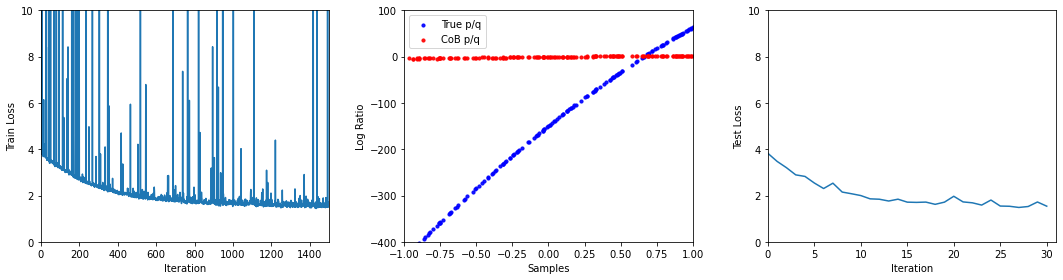

KeyboardInterrupt: 

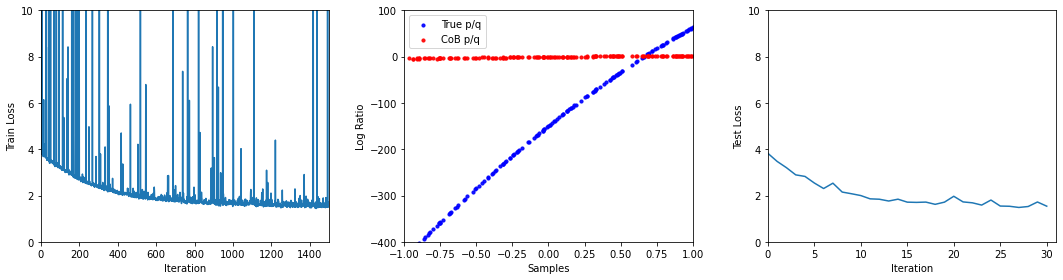

In [4]:
# plotlosses = PlotLosses()
# train(sess, dloss, optim, plotlosses, N=N)


loss_store=[]
test_loss_store=[]
fig, [ax1,ax2,ax3] = plt.subplots(1, 3,figsize=(15,4))

line, = ax1.plot([0,1],[0,1])
x, y = np.random.random((2, 500))
scat1 = ax2.scatter(x,y,label='True p/q',alpha=0.9,s=10.,c='b')
scat2 = ax2.scatter(x,y,label='CoB p/q',alpha=0.9,s=10.,c='r')
test_line, = ax3.plot([0,1],[0,1])

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Train Loss")
ax1.set_xlim([0,N])
ax1.set_ylim([0,10])

ax2.set_xlabel("Samples")
ax2.set_ylabel("Log Ratio")
ax2.legend(loc='best')
ax2.set_xlim([-6,10])
ax2.set_ylim([-1500,5000])

ax3.set_xlabel("Iteration")
ax3.set_ylabel("Test Loss")
ax3.set_xlim([0,N])
ax3.set_ylim([0,10])

plt.tight_layout()

pbar = range(0,N)
for j in pbar:
    for i in range(num_samples//bs):

        ps = p_list[np.random.choice(range(len(p_list)),bs)]
        qs = q_list[np.random.choice(range(len(q_list)),bs)]
        ms = m_list[np.random.choice(range(len(m_list)),bs)]
        feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}
        l,_ = sess.run([dloss, optim],feed_dict=feed_dict)
        loss_store.append(l)
        if i%50==0:
            line.set_data(range(len(loss_store)), loss_store)
            ax1.set_xlim( 0, len(loss_store) )

            ps = p_list_test[np.random.choice(range(len(p_list_test)),bs)]
            qs = q_list[np.random.choice(range(len(q_list)),bs)]
            ms = m_list_test[np.random.choice(range(len(m_list_test)),bs)]
            feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}

            testl, xs, lpq, lpqm, kld_true, kld_cob = sess.run([dloss,m_samples, log_ratio_p_q, log_ratio_p_m, kl_from_pq, kl_from_cob],feed_dict=feed_dict)

            scat2.set_offsets(np.asarray([xs,lpqm[:,0]-lpqm[:,1]]).T)
            scat1.set_offsets(np.asarray([xs, lpq]).T)
            ax2.set_xlim( -1., 1. )
            ax2.set_ylim( -400, 100 )
            
            test_loss_store.append(testl)
            test_line.set_data(range(len(test_loss_store)), test_loss_store)
            ax3.set_xlim( 0, len(test_loss_store) )
            print('epoch: ',j)
            print('KLD: ', kld_true)
            print('CoB: ', kld_cob)
        
            clear_output(wait=True)
            display(fig)
            
            
print('KLD: ', kld_true)
print('CoB: ', kld_cob)

ps = p_list_test[np.random.choice(range(len(p_list_test)),bs)]
qs = q_list[np.random.choice(range(len(q_list)),bs)]
ms = m_list_test[np.random.choice(range(len(m_list_test)),bs)]
        
sample_and_plot(sess, kl_from_pq, kl_from_cob, kld, ps, qs, ms, log_ratio_p_q, log_ratio_p_m, mu_1, mu_2, scale_p, scale_q, mu_3, scale_m)
# with open("../models/kl_utils.py", "a") as f:
#     f.write(" ")
#     f.close()

In [5]:
ps = p_list_test[np.random.choice(range(len(p_list_test)),bs)]
qs = q_list[np.random.choice(range(len(q_list)),bs)]
ms = m_list_test[np.random.choice(range(len(m_list_test)),bs)]
        
sample_and_plot(sess, kl_from_pq, kl_from_cob, kld, ps, qs, ms, log_ratio_p_q, log_ratio_p_m, mu_1, mu_2, scale_p, scale_q, mu_3, scale_m)

TypeError: Fetch argument array([1.8654219, 2.1975555, 2.1357305, 2.1089392, 2.1027296, 2.0635662,
       1.907367 , 1.9077305, 1.877833 , 1.9443195, 1.9277153, 1.9847392,
       1.695134 , 2.0427012, 2.0365894, 2.0145977, 2.0559826, 2.061621 ,
       1.9518727, 2.0327802, 1.9607908, 1.8187155, 2.0307326, 1.8606565,
       2.0107002, 1.8520222, 2.0490835, 1.9950736, 2.1242375, 1.982958 ,
       2.0654273, 1.9501238, 1.926147 , 2.0260305, 1.8210969, 1.9984273,
       1.9693581, 1.8334082, 1.9736323, 1.9516562, 2.2349524, 2.1637359,
       2.0270193, 1.9426658, 2.0611258, 2.0239685, 1.9912816, 2.0517278,
       2.061085 , 2.0644238, 2.086155 , 1.8636572, 2.0411284, 1.95912  ,
       2.0037704, 2.1434016, 2.0090034, 2.0473154, 2.1342425, 2.064986 ,
       1.9921297, 2.0547917, 2.152583 , 2.046934 , 1.996203 , 2.0835843,
       1.8884397, 1.9606011, 1.9918784, 2.0657508, 2.0075796, 2.005409 ,
       1.9443059, 1.9443344, 2.0553267, 1.8889552, 2.0779145, 2.051426 ,
       1.8928688, 2.0715137, 2.067317 , 1.8936456, 1.8910722, 1.8821617,
       1.9889914, 2.1538377, 2.0061557, 1.9214827, 2.0490816, 1.8098432,
       2.0236814, 2.0515528, 1.9275724, 2.1627371, 2.069758 , 1.9032412,
       2.1513648, 2.115444 , 1.939657 , 2.1086462, 2.2552412, 1.997185 ,
       2.0472507, 2.122509 , 1.8883821, 1.9259651, 2.114003 , 1.9869269,
       2.1457665, 2.1002564, 1.9755713, 2.0982928, 1.8837267, 1.8981224,
       2.2530193, 2.040568 , 1.8232497, 1.8566784, 2.045957 , 2.0139537,
       2.0902581, 2.1062567, 1.9434052, 2.005993 , 2.1142495, 2.1082187,
       1.9820727, 2.0328465, 2.1560805, 2.044188 , 2.056334 , 1.9514188,
       2.1592255, 1.8069599, 1.9810692, 1.856318 , 2.0031083, 1.9765884,
       1.9846089, 1.956072 , 1.9547894, 1.8648735, 2.0552926, 2.061795 ,
       1.9207226, 2.1019614, 2.01901  , 2.1097004, 2.02407  , 1.9638929,
       1.8960495, 1.833455 , 1.9594959, 1.8857876, 2.1538563, 1.915187 ,
       1.7499614, 1.9775933, 1.981234 , 2.0710661, 1.9098037, 1.9591907,
       2.234987 , 2.0355632, 2.0121872, 2.076396 , 1.993393 , 2.0258393,
       1.9940641, 1.9444991, 1.8870697, 2.0379155, 2.055931 , 1.8500917,
       2.1103852, 1.955085 , 2.1665769, 2.0424566, 1.9676801, 1.9667585,
       1.9633492, 2.1004963, 1.8827578, 2.1074054, 1.9704323, 2.0019019,
       1.9785689, 1.8793744, 2.020839 , 2.0509796, 2.2229924, 1.8605093,
       2.0129516, 2.134486 , 1.9344414, 1.8711281, 1.9017636, 1.970962 ,
       1.9861463, 1.9895744, 2.0596597, 2.0852468, 1.9237735, 1.8630253,
       1.9364474, 2.130681 , 2.0531013, 2.1431575, 1.8233039, 2.2414165,
       2.2043417, 2.178008 , 2.051153 , 2.055254 , 1.9888495, 2.102437 ,
       1.9199178, 2.0362227, 2.0276155, 2.088104 , 2.1543233, 2.063622 ,
       2.0445862, 1.936782 , 2.1531613, 2.1325927, 1.8979104, 1.9802256,
       2.1945407, 1.8801751, 1.9011354, 1.9487367, 1.819632 , 1.8786093,
       2.0930326, 2.116372 , 1.9911766, 2.167138 , 1.8233294, 2.203879 ,
       2.1312385, 1.8231099, 2.004325 , 1.8994882, 2.136447 , 2.0711067,
       2.0160353, 2.1270764, 2.0682387, 2.018396 , 2.1432033, 2.2229648,
       1.9980628, 1.8978634, 1.9811496, 2.0008698, 1.9657242, 2.0780127,
       2.0396905, 1.8636926, 1.9185805, 2.0100255, 1.8998545, 1.9616259,
       1.9651117, 2.0383964, 2.0354385, 1.8929874, 2.010974 , 2.017306 ,
       1.9820234, 1.9195893, 1.9523463, 2.0609121, 1.9765694, 2.0042036,
       2.0407956, 2.0348895, 2.1534877, 1.9699079, 2.0594506, 2.0498903,
       1.9513882, 1.9391098, 1.9944174, 1.9175103, 2.1055787, 1.9017264,
       2.0907521, 2.123268 , 1.9229623, 1.9170046, 2.0510504, 2.116082 ,
       1.992574 , 1.9228145, 1.919255 , 2.02248  , 2.0705802, 1.9956083,
       1.9475284, 2.0788639, 2.1250849, 2.1573894, 1.9858968, 2.028444 ,
       1.9661502, 1.9807788, 2.0154326, 2.0725136, 1.9764662, 1.9204234,
       2.1491048, 2.0733685, 1.8769157, 2.0352657, 2.0713487, 2.0879612,
       1.9941818, 1.932777 , 1.9634038, 2.125091 , 2.112381 , 2.0335734,
       2.2488925, 1.9741459, 2.036112 , 2.1199534, 2.1347682, 1.9538622,
       1.9836658, 2.003674 , 1.9120182, 2.0605888, 2.1037703, 1.9808952,
       2.0251787, 2.0503619, 2.065582 , 1.9361473, 2.0327473, 2.0685308,
       2.1823924, 1.9449438, 2.030153 , 2.099775 , 2.0529494, 1.8566617,
       1.864986 , 1.9152492, 2.048271 , 2.2010207, 2.0380244, 2.3100526,
       2.0252216, 2.0906951, 1.985851 , 2.039298 , 2.0164382, 2.1220517,
       1.9187176, 2.081197 , 1.8847811, 1.9722269, 2.0432982, 1.8686901,
       1.9049264, 1.8077533, 1.9486483, 2.0921345, 2.0930164, 2.0297136,
       1.8569776, 2.125936 , 1.865938 , 1.9699055, 2.075267 , 2.0538425,
       1.8922474, 2.071622 , 2.0390954, 1.8950214, 2.1154833, 2.032021 ,
       2.0816734, 1.9577699, 1.962571 , 1.889414 , 1.9421288, 1.9345027,
       2.0178564, 1.9972911, 1.8666799, 2.1506166, 1.7556301, 2.1172955,
       1.8120893, 1.9817117, 2.0704176, 1.9625106, 2.0174587, 2.1149802,
       1.9132996, 1.8705112, 1.852652 , 2.09443  , 1.979127 , 2.0383084,
       2.0242674, 1.9778641, 1.960145 , 1.9589088, 1.9136   , 2.085983 ,
       2.011373 , 1.8783301, 2.2002337, 1.8190526, 2.114614 , 1.8489418,
       1.8761176, 2.058416 , 2.0983326, 2.0341997, 2.1334162, 2.0932326,
       1.8012915, 2.079991 , 2.0200324, 1.9971498, 2.069171 , 2.0264785,
       1.9648093, 2.0505295, 2.0079937, 1.7439127, 2.0844994, 2.091299 ,
       2.034783 , 2.0117843, 1.8692949, 2.0899892, 2.0339525, 1.9612634,
       2.1642358, 1.8460659, 1.9148293, 2.0279918, 2.0046644, 2.1203682,
       2.0319295, 1.9511082, 2.162214 , 2.06977  , 1.9911845, 2.0818896,
       1.9643215, 2.0143147, 2.0516417, 2.051511 , 1.910132 , 2.1572645,
       2.1489115, 2.0146992, 1.9491345, 2.0219643, 2.204611 , 1.9940805,
       1.9393895, 1.9979424, 1.9813461, 1.8555312, 1.8292487, 2.0699575,
       2.0519702, 1.8362075, 1.8792703, 2.2929866, 2.1572473, 2.2402775,
       2.013396 , 1.8781621, 2.0179877, 2.0973992, 2.1572955, 1.9576926,
       1.9399191, 1.9905062, 1.9435359, 1.9334903, 1.9127337, 1.9574097,
       1.9561778, 2.0532603, 1.8417983, 2.0702806, 2.022363 , 2.0557802,
       1.9263593, 1.7554201], dtype=float32) has invalid type <class 'numpy.ndarray'>, must be a string or Tensor. (Can not convert a ndarray into a Tensor or Operation.)

In [4]:
with open("../models/kl_utils.py", "a") as f:
    f.write(" ")
    f.close()
    